In [25]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split,GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score, mean_squared_error
import weather_and_time_functions as weather_time
import matplotlib.pyplot as plt
import seaborn as sns

pd.set_option('display.max_columns',None)
scaler = StandardScaler()

In [7]:
flight_df = pd.read_feather('data/v2_clean_flight')
flight_test_df = pd.read_feather('data/v1_clean_flight_test')
fuel_consumption_df = pd.read_feather('data/v1_clean_fuel_consumption')
passenger_df = pd.read_feather('data/v1_clean_passenger')

In [8]:
def duration_to_rank(x):
    """ 
    Transforms the rank of a flight distance

    Parameters:
        x(str): short,medium or long flight distance

    Returns:
        An integer of 0, 1 or 2 depending on their flight distance
    """
    if x == 'short':
        return 0
    elif x =='medium':
        return 1
    else:
        return 2

flight_df['flight_duration'] = flight_df['flight_duration'].apply(lambda x: duration_to_rank(x))

In [9]:
dep_hour = weather_time.obtain_depart_hour(flight_df)
arr_hour = weather_time.obtain_arrival_hour(flight_df)
flight_df['dep_hour'] = dep_hour
flight_df['arr_hour'] = arr_hour
flight_df.drop('hour',axis=1,inplace=True)

flight_df['day'] = pd.to_datetime(flight_df['fl_date'],yearfirst=True).dt.day
flight_df['month'] = flight_df['month'].astype(int)
flight_df['dep_hour'] = flight_df['dep_hour'].astype(int)
flight_df['arr_hour'] = flight_df['arr_hour'].astype(int)

In [10]:
num_cols = ['crs_elapsed_time','distance']
rank_cols = ['month','dep_hour','arr_hour']
dum_cols = ['origin','dest','op_unique_carrier']
y_target = flight_df['arr_delay'].fillna(0)


In [11]:
flight_df

,fl_date,mkt_unique_carrier,branded_code_share,mkt_carrier,mkt_carrier_fl_num,op_unique_carrier,tail_num,op_carrier_fl_num,origin_airport_id,origin,origin_city_name,dest_airport_id,dest,dest_city_name,crs_dep_time,dep_delay,taxi_out,taxi_in,crs_arr_time,arr_delay,crs_elapsed_time,distance,month,flight_duration,state/country,dep_hour,arr_hour,day
0,2019-10-28,AA,AA_CODESHARE,AA,4377,YX,N115HQ,4377,10785,BTV,"Burlington, VT",14100,PHL,"Philadelphia, PA",543,-4.0,10.0,8.0,713,-15.0,90.0,335.0,10,0,VT,5,7,28
1,2018-06-04,DL,DL_CODESHARE,DL,5491,EV,N741EV,5491,12953,LGA,"New York, NY",11042,CLE,"Cleveland, OH",1415,-5.0,24.0,7.0,1603,-16.0,108.0,419.0,6,0,NY,14,16,4
2,2018-07-31,WN,WN,WN,562,WN,N479WN,562,13198,MCI,"Kansas City, MO",13487,MSP,"Minneapolis, MN",940,-4.0,9.0,5.0,1055,-8.0,75.0,393.0,7,0,MO,9,10,31
3,2019-10-05,WN,WN,WN,4755,WN,N452WN,4755,14107,PHX,"Phoenix, AZ",14570,RNO,"Reno, NV",1755,21.0,6.0,2.0,1935,13.0,100.0,601.0,10,0,AZ,17,19,5
4,2018-05-11,WN,WN,WN,1002,WN,N706SW,1002,11884,GEG,"Spokane, WA",13796,OAK,"Oakland, CA",515,1.0,9.0,5.0,720,-14.0,125.0,723.0,5,1,WA,5,7,11
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99993,2018-12-15,AA,AA,AA,564,AA,N549UW,564,14747,SEA,"Seattle, WA",14100,PHL,"Philadelphia, PA",2226,-8.0,18.0,8.0,627,-2.0,301.0,2378.0,12,1,WA,22,6,15
99994,2018-04-08,UA,UA_CODESHARE,UA,6054,YV,N86324,6054,12266,IAH,"Houston, TX",13256,MFE,"Mission/McAllen/Edinburg, TX",735,76.0,13.0,3.0,858,62.0,83.0,316.0,4,0,TX,7,8,8
99995,2019-02-01,AA,AA_CODESHARE,AA,4357,YX,N437YX,4357,10868,CAE,"Columbia, SC",11057,CLT,"Charlotte, NC",528,-4.0,14.0,10.0,626,-11.0,58.0,88.0,2,0,SC,5,6,1
99996,2018-07-08,AS,AS,AS,803,AS,N534AS,803,14831,SJC,"San Jose, CA",13830,OGG,"Kahului, HI",800,0.0,12.0,13.0,1022,1.0,322.0,2355.0,7,1,CA,8,10,8


In [13]:
flight_model = flight_df[['crs_elapsed_time','distance','month','dep_hour','arr_hour','origin','dest','op_unique_carrier']]
flight_model = pd.get_dummies(flight_model, columns=dum_cols)
flight_model

,crs_elapsed_time,distance,month,dep_hour,arr_hour,origin_ABE,origin_ABI,origin_ABQ,origin_ABR,origin_ABY,origin_ACK,origin_ACT,origin_ACV,origin_ACY,origin_ADQ,origin_AEX,origin_AGS,origin_AKN,origin_ALB,origin_ALO,origin_ALW,origin_AMA,origin_ANC,origin_APN,origin_ART,origin_ASE,origin_ATL,origin_ATW,origin_ATY,origin_AUS,origin_AVL,origin_AVP,origin_AZA,origin_AZO,origin_BDL,origin_BET,origin_BFF,origin_BFL,origin_BFM,origin_BGM,origin_BGR,origin_BHM,origin_BIL,origin_BIS,origin_BJI,origin_BKG,origin_BLI,origin_BLV,origin_BMI,origin_BNA,origin_BOI,origin_BOS,origin_BPT,origin_BQK,origin_BQN,origin_BRD,origin_BRO,origin_BRW,origin_BTM,origin_BTR,origin_BTV,origin_BUF,origin_BUR,origin_BWI,origin_BZN,origin_CAE,origin_CAK,origin_CDC,origin_CDV,origin_CGI,origin_CHA,origin_CHO,origin_CHS,origin_CID,origin_CIU,origin_CKB,origin_CLE,origin_CLL,origin_CLT,origin_CMH,origin_CMI,origin_CMX,origin_CNY,origin_COD,origin_COS,origin_COU,origin_CPR,origin_CRP,origin_CRW,origin_CSG,origin_CVG,origin_CWA,origin_CYS,origin_DAB,origin_DAL,origin_DAY,origin_DBQ,origin_DCA,origin_DEN,origin_DFW,origin_DHN,origin_DIK,origin_DLG,origin_DLH,origin_DRO,origin_DRT,origin_DSM,origin_DTW,origin_DUT,origin_DVL,origin_EAR,origin_EAT,origin_EAU,origin_ECP,origin_EGE,origin_EKO,origin_ELM,origin_ELP,origin_ERI,origin_ESC,origin_EUG,origin_EVV,origin_EWN,origin_EWR,origin_EYW,origin_FAI,origin_FAR,origin_FAT,origin_FAY,origin_FCA,origin_FLG,origin_FLL,origin_FLO,origin_FNT,origin_FSD,origin_FSM,origin_FWA,origin_GCC,origin_GCK,origin_GEG,origin_GFK,origin_GGG,origin_GJT,origin_GNV,origin_GPT,origin_GRB,origin_GRI,origin_GRK,origin_GRR,origin_GSO,origin_GSP,origin_GTF,origin_GTR,origin_GUC,origin_GUM,origin_HDN,origin_HGR,origin_HHH,origin_HIB,origin_HLN,origin_HNL,origin_HOB,origin_HOU,origin_HPN,origin_HRL,origin_HSV,origin_HTS,origin_HVN,origin_HYA,origin_HYS,origin_IAD,origin_IAG,origin_IAH,origin_ICT,origin_IDA,origin_ILM,origin_IMT,origin_IND,origin_INL,origin_IPT,origin_ISN,origin_ISP,origin_ITH,origin_ITO,origin_JAC,origin_JAN,origin_JAX,origin_JFK,origin_JHM,origin_JLN,origin_JMS,origin_JNU,origin_KOA,origin_KTN,origin_LAN,origin_LAR,origin_LAS,origin_LAW,origin_LAX,origin_LBB,origin_LBE,origin_LBF,origin_LBL,origin_LCH,origin_LCK,origin_LEX,origin_LFT,origin_LGA,origin_LGB,origin_LIH,origin_LIT,origin_LNK,origin_LNY,origin_LRD,origin_LSE,origin_LWB,origin_LWS,origin_LYH,origin_MAF,origin_MBS,origin_MCI,origin_MCO,origin_MDT,origin_MDW,origin_MEI,origin_MEM,origin_MFE,origin_MFR,origin_MGM,origin_MHK,origin_MHT,origin_MIA,origin_MKE,origin_MKG,origin_MKK,origin_MLB,origin_MLI,origin_MLU,origin_MMH,origin_MOB,origin_MOT,origin_MQT,origin_MRY,origin_MSN,origin_MSO,origin_MSP,origin_MSY,origin_MTJ,origin_MVY,origin_MYR,origin_OAJ,origin_OAK,origin_OGD,origin_OGG,origin_OGS,origin_OKC,origin_OMA,origin_OME,origin_ONT,origin_ORD,origin_ORF,origin_ORH,origin_OTH,origin_OTZ,origin_OWB,origin_PAE,origin_PAH,origin_PBG,origin_PBI,origin_PDX,origin_PGD,origin_PGV,origin_PHF,origin_PHL,origin_PHX,origin_PIA,origin_PIB,origin_PIE,origin_PIH,origin_PIR,origin_PIT,origin_PLN,origin_PNS,origin_PPG,origin_PQI,origin_PRC,origin_PSC,origin_PSE,origin_PSG,origin_PSM,origin_PSP,origin_PUB,origin_PUW,origin_PVD,origin_PVU,origin_PWM,origin_RAP,origin_RDD,origin_RDM,origin_RDU,origin_RFD,origin_RHI,origin_RIC,origin_RKS,origin_RNO,origin_ROA,origin_ROC,origin_ROW,origin_RST,origin_RSW,origin_SAF,origin_SAN,origin_SAT,origin_SAV,origin_SBA,origin_SBN,origin_SBP,origin_SBY,origin_SCC,origin_SCE,origin_SCK,origin_SDF,origin_SEA,origin_SFB,origin_SFO,origin_SGF,origin_SGU,origin_SHD,origin_SHV,origin_SIT,origin_SJC,origin_SJT,origin_SJU,origin_SLC,origin_SLN,origin_SMF,origin_SMX,origin_SNA,origin_SPI,origin_SPN,origin_SPS,origin_SRQ,origin_STC,origin_STL,origin_STS,origin_STT,origin_STX,origin_SUN,origin_SUX,origin_SWF,origin_SWO,origin_SYR,origin_TLH,origin_TOL,origin_TPA,origin_TRI,origin_TTN,origin_TUL,origin_TUS,origin_TVC,origin_TWF,origin_TXK,origin_TYR,origin_TYS,

In [14]:
x_train,x_test,y_train,y_test = train_test_split(flight_model,y_target,test_size=0.3)

In [15]:
x_train_scaled = scaler.fit_transform(x_train[num_cols])
x_test_scaled = scaler.fit_transform(x_test[num_cols])
x_train[num_cols] = x_train_scaled
x_test[num_cols] = x_test_scaled

In [ ]:
## Took 67minutes to run this fit. best params was squared error, max_depth 2, n_estimators = 50

# param_grid = {
#     'max_depth': [2,3,4,5,6],
#     'criterion': ['absoulate_error','squared_error'],
#     'n_estimators': [10,30,50,70,100]
# }
# rforest = RandomForestRegressor()
# regCV = GridSearchCV(estimator=rforest,cv=5,param_grid=param_grid,return_train_score=True)
# regCV.fit(x_train,y_train)
# regCV.best_params_ (best params depth 2, n_est 50)

In [ ]:
regressor = RandomForestRegressor(random_state=0,max_depth=2,n_estimators=50)
regressor.fit(x_train,y_train)
y_pred = regressor.predict(x_test)

In [24]:
print("R2 Score: ",r2_score(y_test,y_pred))
print("Mean Squared Error: ", mean_squared_error(y_test,y_pred))
print("Root Mean Squared Error: ",mean_squared_error(y_test,y_pred, squared=False))

R2 Score:  0.005463569511063748
Mean Squared Error:  2478.711658818404
Root Mean Squared Error:  49.78666145483551


<AxesSubplot: title={'center': 'XGBoost Model on Flight Arrival Delays'}, xlabel='Actual results', ylabel='Predicted results'>

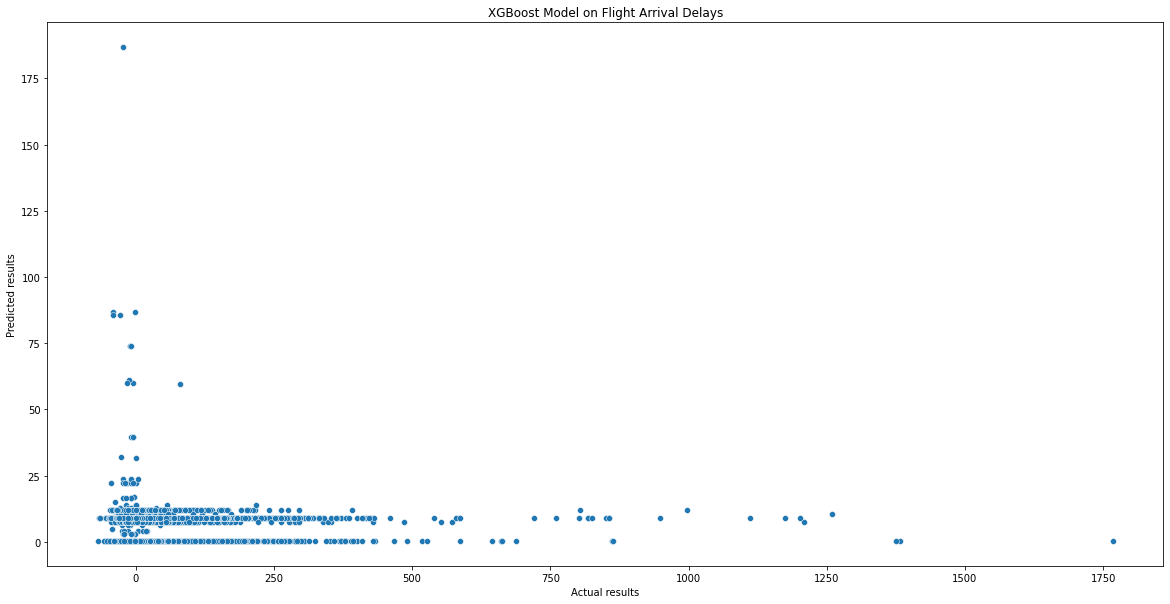

In [26]:
plt.figure(figsize=(20,10))
plt.xlabel('Actual results')
plt.ylabel('Predicted results')
plt.title('XGBoost Model on Flight Arrival Delays')
sns.scatterplot(x=y_test,y=y_pred)

# 500 Entries of weather stats for model

Only used 500 entries of weather data, did not have any good value adding it into the model

In [ ]:
# weather_flight_model = flight_df[:500].copy()
# weather_flight_model

In [ ]:
# lat_list,lon_list = weather_time.lat_grabber(weather_flight_model)

In [ ]:
# weather_flight_model['lat'] = lat_list
# weather_flight_model['lon'] = lon_list

In [ ]:
# cloud,rain,snow,sunny = weather_time.weather_grabber(weather_flight_model)

In [ ]:
# small_weather_model = weather_flight_model[:500].copy()
# small_weather_model['cloud'] = cloud
# small_weather_model['sunny'] = sunny
# small_weather_model['snow'] = snow
# small_weather_model['rain'] = rain

In [ ]:
#small_weather_model.to_feather('data/flight_weather_model_500')

In [ ]:
# num_cols = ['crs_elapsed_time','distance','cloud','sunny','rain','snow']
# rank_cols = ['month','flight_duration','hour']
# dum_cols = ['origin','dest']
# y_target_weather = flight_df['arr_delay'].fillna(0)[:500]
# small_weather_model = small_weather_model[['crs_elapsed_time','distance','cloud','sunny','rain','snow','month','flight_duration','hour','origin','dest']]
# small_weather_model

In [ ]:
# small_weather_model = pd.get_dummies(small_weather_model,columns=dum_cols)
# small_weather_model

In [ ]:
# x_train,x_test,y_train,y_test = train_test_split(small_weather_model,y_target_weather,test_size=0.3)
# x_train_scaled = scaler.fit_transform(x_train[num_cols])
# x_test_scaled = scaler.fit_transform(x_test[num_cols])

In [ ]:
# x_train[num_cols] = x_train_scaled
# x_test[num_cols] = x_test_scaled
# regressor = RandomForestRegressor(n_estimators=100,random_state=0)
# regressor.fit(x_train,y_train)
# y_pred = regressor.predict(x_test)

In [ ]:
# r2_score(y_test,y_pred)